In [1]:
import numpy as np
import pandas as pd
import yaml
import torch
from copy import deepcopy
import matplotlib.pyplot as plt
from celldreamer.eval.eval_utils import normalize_and_compute_metrics
import scipy.sparse as sp
from tqdm import tqdm 

from torch import nn
import pickle
import scanpy as sc    

from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.fm.fm import FM
from celldreamer.eval.optimal_transport import wasserstein
import random
from celldreamer.models.base.encoder_model import EncoderModel
from celldreamer.models.base.utils import unsqueeze_right

from celldreamer.paths import DATA_DIR
import time


device  = "cuda" if torch.cuda.is_available() else "cpu"

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Step 1: Initialize data

In [2]:
dataset_config = {'dataset_path': DATA_DIR / 'processed_full_genome' / 'hlca_core' / 'hlca_core_train.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['cell_type'],
                    'conditioning_covariate': 'cell_type',
                    'subsample_frac': 1,
                    'encoder_type': 'learnt_autoencoder',
                    'target_max': 1,
                    'target_min': -1,
                    'n_dimensions': None,
                    'one_hot_encode_features': True,
                    'split_rates': [0.90, 0.05, 0.05],
                    'cov_embedding_dimensions': None}

data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                                layer_key=dataset_config["layer_key"],
                                covariate_keys=dataset_config["covariate_keys"],
                                subsample_frac=dataset_config["subsample_frac"], 
                                encoder_type=dataset_config["encoder_type"])

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}
n_cat = len(dataset.id2cov["cell_type"])

id2cov = dataset.id2cov

# del dataset

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


## Step 2: Initialize encoder

In [3]:
encoder_config = {
    "x0_from_x_kwargs": {
        "dims": [512, 256, 100],
        "batch_norm": True,
        "dropout": False,
        "dropout_p": 0.0
    },
    "learning_rate": 0.001,
    "weight_decay": 0.00001,
    "covariate_specific_theta": False
}

state_dict_path = "/home/icb/alessandro.palma/environment/cfgen/project_folder/experiments/off_train_autoencoder_hlca_core_whole_genome/80ee94e4-ba9f-4481-a2db-8fa005a5cf67/checkpoints/epoch_99.ckpt"

In [4]:
encoder_model = EncoderModel(in_dim=in_dim,
                              n_cat=n_cat,
                              conditioning_covariate=dataset_config["conditioning_covariate"], 
                              encoder_type=dataset_config["encoder_type"],
                              **encoder_config)

encoder_model.load_state_dict(torch.load(state_dict_path)["state_dict"])

encoder_model.eval()

EncoderModel(
  (x0_from_x): MLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=27997, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (1): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (2): Linear(in_features=256, out_features=100, bias=True)
    )
  )
  (x_from_x0): MLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=100, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (1): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_runn

## Step 3: Initialize FM model

In [5]:
generative_model_config = {'learning_rate': 0.0001,
                            'weight_decay': 0.00001,
                            'antithetic_time_sampling': True,
                            'sigma': 0.0001}

In [6]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/cfgen/project_folder/experiments/off_fm_resnet_autoencoder_hlca_core_whole_genome/f5516523-21b1-422d-b9c7-fd7cbc75a810/checkpoints/last.ckpt")

denoising_model = ckpt["hyper_parameters"]["denoising_model"]
denoising_model.multimodal = False

In [7]:
ckpt["hyper_parameters"]

{'encoder_model': EncoderModel(
   (x0_from_x): MLP(
     (net): Sequential(
       (0): Sequential(
         (0): Linear(in_features=27997, out_features=512, bias=True)
         (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (2): ELU(alpha=1.0)
       )
       (1): Sequential(
         (0): Linear(in_features=512, out_features=256, bias=True)
         (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (2): ELU(alpha=1.0)
       )
       (2): Linear(in_features=256, out_features=100, bias=True)
     )
   )
   (x_from_x0): MLP(
     (net): Sequential(
       (0): Sequential(
         (0): Linear(in_features=100, out_features=256, bias=True)
         (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (2): ELU(alpha=1.0)
       )
       (1): Sequential(
         (0): Linear(in_features=256, out_features=512, bias=True)
         (1): BatchNorm1d(512, eps=1

In [8]:
print(ckpt["hyper_parameters"]["feature_embeddings"]["cell_type"].embeddings.weight)
feature_embeddings = ckpt["hyper_parameters"]["feature_embeddings"]

Parameter containing:
tensor([[-1.2769e+00,  7.5715e-01, -1.0924e+00,  ..., -1.6436e-01,
          7.0600e-01,  9.7933e-01],
        [ 1.9863e-01,  6.9801e-01, -9.6553e-01,  ...,  7.7968e-01,
         -1.9831e-01,  1.1236e+00],
        [-8.2322e-01, -2.4582e+00, -1.2183e+00,  ...,  7.8510e-01,
          2.1482e-03,  1.2392e+00],
        ...,
        [-8.2123e-01,  1.0490e+00, -1.4387e+00,  ...,  7.0423e-02,
          5.0027e-01,  2.8660e-01],
        [ 1.1899e-01,  4.9095e-01,  9.3515e-01,  ..., -9.6862e-02,
          7.6541e-01, -2.9512e-01],
        [-5.7512e-01, -2.3311e-01,  6.7195e-01,  ..., -1.6282e+00,
          1.3942e+00, -7.7802e-01]], device='cuda:0', requires_grad=True)


Initializations

In [9]:
generative_model = FM(
            encoder_model=encoder_model,
            denoising_model=denoising_model,
            feature_embeddings=feature_embeddings,
            plotting_folder=None,
            in_dim=512,
            size_factor_statistics=size_factor_statistics,
            encoder_type=dataset_config["encoder_type"],
            conditioning_covariate=dataset_config["conditioning_covariate"],
            model_type=denoising_model.model_type, 
            **generative_model_config  # model_kwargs should contain the rest of the arguments
            )

generative_model.load_state_dict(ckpt["state_dict"])
generative_model.to("cuda")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


FM(
  (encoder_model): EncoderModel(
    (x0_from_x): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=27997, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=512, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (2): Linear(in_features=256, out_features=100, bias=True)
      )
    )
    (x_from_x0): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=100, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
       

In [10]:
del ckpt
del encoder_model

# Save three copies of generated datasest 

In [11]:
adata_original = sc.read_h5ad(DATA_DIR / 'processed_full_genome' / 'hlca_core' / 'hlca_core_test.h5ad')
adata_original.X = adata_original.layers["X_counts"].copy()
adata_original.obs["size_factor"]=adata_original.X.A.sum(1)
saving_dir = DATA_DIR / "generated" / "hlca_core"

In [12]:
adata_original

AnnData object with n_obs × n_vars = 116989 × 27997
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'dataset', 'entropy_dataset_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_subject_ID_leiden_3', 'fresh_or_frozen', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_5', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'n_genes_detected', 'original_ann_highest_res', 'original_ann_level_1', '

In [14]:
# index_range = len(adata_original)
# num_indices = 1000
# times = []

# for it in tqdm(range(3)):
#     X_generated_list = []
#     classes_str = []
#     t0 = time.time()
#     for _ in range(116):
        
#         # Generate random dummy indices without replacement
#         indices = random.sample(range(index_range), num_indices)
#         adata_indices = adata_original[indices]
        
#         classes =  list(adata_indices.obs.cell_type)
#         classes_str += classes
#         classes = torch.tensor([id2cov["cell_type"][c] for  c in classes])
    
#         X_generated = generative_model.batched_sample(batch_size=100,
#                                                         repetitions=10,
#                                                         n_sample_steps=2, 
#                                                         covariate="cell_type", 
#                                                         covariate_indices=classes, 
#                                                         log_size_factor=None)
    
#         X_generated_list.append(X_generated.to("cpu"))

    
#     t1 = time.time()
#     times.append(t1-t0)
    
    # X_generated_list = torch.cat(X_generated_list, dim=0)
    
    # adata_generated = sc.AnnData(X=sp.csr_matrix(deepcopy(X_generated_list).cpu().numpy()))
    # del X_generated_list
    # adata_generated.obs["size_factor"] = adata_generated.X.sum(1)
    # adata_generated.obs["cell_type"] = classes_str
    # adata_generated.obs["cell_type"] = adata_generated.obs["cell_type"].astype("category")
    # adata_generated.layers["X_counts"] = adata_generated.X.copy()
    # sc.pp.normalize_total(adata_generated, target_sum=10000)
    # sc.pp.log1p(adata_generated)
    # sc.tl.pca(adata_generated)
    # adata_generated.write_h5ad(f"/home/icb/alessandro.palma/environment/celldreamer/project_folder/datasets/generated/hlca_core/generated_cells_{it}.h5ad")

## Time generation

In [15]:
index_range = len(adata_original)
num_indices = 1000
times = []

for it in tqdm(range(3)):
    # X_generated_list = []
    # classes_str = []
    # for _ in range(116):
        
    indices = random.sample(range(index_range), 116900)
    adata_indices = adata_original[indices]
        
    classes =  list(adata_indices.obs.cell_type)
    # classes_str += classes
    classes = torch.tensor([id2cov["cell_type"][c] for  c in classes])
    
    t0 = time.time()
    X_generated = generative_model.batched_sample(batch_size=11690,
                                                        repetitions=10,
                                                        n_sample_steps=2, 
                                                        covariate="cell_type", 
                                                        covariate_indices=classes, 
                                                        log_size_factor=None)
    # X_generated_list.append(X_generated.to("cpu"))
    t1 = time.time()
    times.append(t1-t0)
    
    # X_generated_list = torch.cat(X_generated_list, dim=0)
    
    # adata_generated = sc.AnnData(X=sp.csr_matrix(deepcopy(X_generated_list).cpu().numpy()))
    # del X_generated_list
    # adata_generated.obs["size_factor"] = adata_generated.X.sum(1)
    # adata_generated.obs["cell_type"] = classes_str
    # adata_generated.obs["cell_type"] = adata_generated.obs["cell_type"].astype("category")
    # adata_generated.layers["X_counts"] = adata_generated.X.copy()
    # sc.pp.normalize_total(adata_generated, target_sum=10000)
    # sc.pp.log1p(adata_generated)
    # sc.tl.pca(adata_generated)
    # adata_generated.write_h5ad(f"/home/icb/alessandro.palma/environment/celldreamer/project_folder/datasets/generated/hlca_core/generated_cells_{it}.h5ad")

100%|██████████| 3/3 [00:28<00:00,  9.57s/it]


In [16]:
print("Mean generation time", np.mean(times))

Mean generation time 8.61815603574117


In [17]:
print("Mean generation time", np.std(times)/np.sqrt(3))

Mean generation time 0.114771408579674


In [18]:
joint_adata = sc.AnnData(X=np.concatenate([adata_original.layers["X_counts"].A, X_generated], axis=0), 
                        obs={"dataset_type": ["real" for _ in range(adata_original.shape[0])] + ["generated" for _ in range(X_generated.shape[0])]})

In [19]:
sc.pp.normalize_total(joint_adata, target_sum=1e4)

In [20]:
sc.pp.log1p(joint_adata)

In [21]:
sc.tl.pca(joint_adata)
sc.pp.neighbors(joint_adata)
sc.tl.umap(joint_adata)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pynndescent/pynndescent_.py:346: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/reference/deprecation.html#deprecation-of-old-style-numba-captured-errors
Exception origin:
  File "/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/numba/core/types/functions.py", line 486, in __getnewargs__
    raise ReferenceError("underlying object has vanished")

  init_rp_tree(data, dist, current_graph, leaf_array)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pynndescent/pynndescent_.py:348: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style'

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


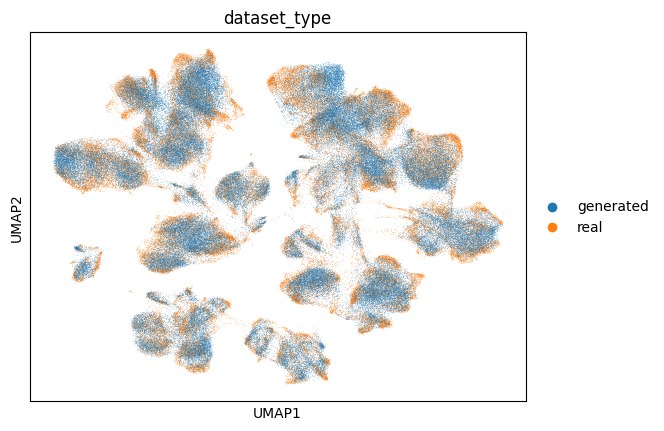

In [22]:
sc.pl.umap(joint_adata, color="dataset_type")